In [1]:
import json
import multiprocessing
import hashing.lsh_main as lsh
# import graph.graph_main as graph
import time
from pathlib import Path
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import graph.random_walk_ori as random_walk
import pandas as pd
import lshashpy3 as lshash
import math 
from scipy import stats

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

random.seed(11)


# DBA

In [2]:
# data = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan/Electric.csv')
# data = data['Electric'].tolist()
# df_segments = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan/fake_noise_23_raw_f3.txt', header = None)


data = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan_Sauerstoff/Sauerstoff.csv')
data = data['Sauerstoff'].tolist()
df_segments = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan_Sauerstoff/fake_noise_23_raw_f3.txt', header = None)


data = stats.zscore(np.array(data))
data = data.tolist()


window = 3072

to_generate = 100

# data = data[:window * 6 ]
len(data)

#define moving average function
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

#calculate moving average using previous 3 time periods

# data = moving_avg(data, 200).tolist()


/tmp/ipykernel_940158/2216285503.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  series = np.array(series)
 15%|███████████████████▏                                                                                                            | 3/20 [00:00<00:00, 26.80it/s]

hello



 15%|███████████████████▏                                                                                                            | 3/20 [00:00<00:00, 26.20it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.32it/s]


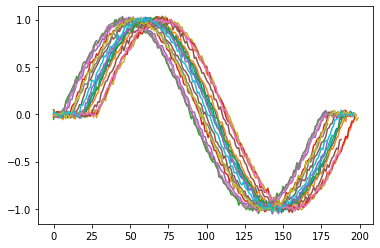

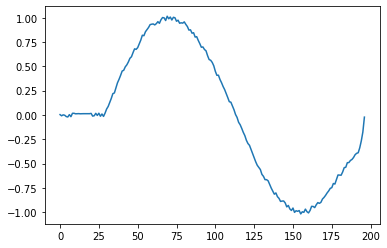

In [3]:
'''
/*******************************************************************************
 * Copyright (C) 2018 Francois Petitjean
 *
 * This program is free software: you can redistribute it and/or modify
 * it under the terms of the GNU General Public License as published by
 * the Free Software Foundation, version 3 of the License.
 *
 * This program is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU General Public License for more details.
 *
 * You should have received a copy of the GNU General Public License
 * along with this program.  If not, see <http://www.gnu.org/licenses/>.
 ******************************************************************************/
'''
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce



def performDBA(series, n_iterations=10):
    n_series = len(series)
    max_length = reduce(max, map(len, series))

    cost_mat = np.zeros((max_length, max_length))
    delta_mat = np.zeros((max_length, max_length))
    path_mat = np.zeros((max_length, max_length), dtype=np.int8)

    medoid_ind = approximate_medoid_index(series,cost_mat,delta_mat)
    center = series[medoid_ind]
    print('hello')
    for i in tqdm(range(0,n_iterations)):
        center = DBA_update(center, series, cost_mat, path_mat, delta_mat)

    return center

def approximate_medoid_index(series,cost_mat,delta_mat):
    if len(series)<=50:
        indices = range(0,len(series))
    else:
        indices = np.random.choice(range(0,len(series)),50,replace=False)

    medoid_ind = -1
    best_ss = 1e20
    for index_candidate in tqdm(indices):
        candidate = series[index_candidate]
        ss = sum_of_squares(candidate,series,cost_mat,delta_mat)
        if(medoid_ind==-1 or ss<best_ss):
            best_ss = ss
            medoid_ind = index_candidate
    return medoid_ind

def sum_of_squares(s,series,cost_mat,delta_mat):
    return sum(map(lambda t:squared_DTW(s,t,cost_mat,delta_mat),series))

def DTW(s,t,cost_mat,delta_mat):
    return np.sqrt(squared_DTW(s,t,cost_mat,delta_mat))

def squared_DTW(s,t,cost_mat,delta_mat):
    s_len = len(s)
    t_len = len(t)
    length = len(s)
    fill_delta_mat_dtw(s, t, delta_mat)
    cost_mat[0, 0] = delta_mat[0, 0]
    for i in range(1, s_len):
        cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]

    for j in range(1, t_len):
        cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]

    for i in range(1, s_len):
        for j in range(1, t_len):
            diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
            if(diag <=left):
                if(diag<=top):
                    res = diag
                else:
                    res = top
            else:
                if(left<=top):
                    res = left
                else:
                    res = top
            cost_mat[i, j] = res+delta_mat[i, j]
    return cost_mat[s_len-1,t_len-1]

def fill_delta_mat_dtw(center, s, delta_mat):
    slim = delta_mat[:len(center),:len(s)]
    np.subtract.outer(center, s,out=slim)
    np.square(slim, out=slim)

def DBA_update(center, series, cost_mat, path_mat, delta_mat):
    options_argmin = [(-1, -1), (0, -1), (-1, 0)]
    updated_center = np.zeros(center.shape)
    n_elements = np.array(np.zeros(center.shape), dtype=int)
    center_length = len(center)
    for s in tqdm(series):
        s_len = len(s)
        fill_delta_mat_dtw(center, s, delta_mat)
        cost_mat[0, 0] = delta_mat[0, 0]
        path_mat[0, 0] = -1

        for i in range(1, center_length):
            cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]
            path_mat[i, 0] = 2

        for j in range(1, s_len):
            cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]
            path_mat[0, j] = 1

        for i in range(1, center_length):
            for j in range(1, s_len):
                diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
                if(diag <=left):
                    if(diag<=top):
                        res = diag
                        path_mat[i,j] = 0
                    else:
                        res = top
                        path_mat[i,j] = 2
                else:
                    if(left<=top):
                        res = left
                        path_mat[i,j] = 1
                    else:
                        res = top
                        path_mat[i,j] = 2

                cost_mat[i, j] = res+delta_mat[i, j]

        i = center_length-1
        j = s_len-1

        while(path_mat[i, j] != -1):
            updated_center[i] += s[j]
            n_elements[i] += 1
            move = options_argmin[path_mat[i, j]]
            i += move[0]
            j += move[1]
        assert(i == 0 and j == 0)
        updated_center[i] += s[j]
        n_elements[i] += 1

    return np.divide(updated_center, n_elements)

def main():
    #generating synthetic data
    n_series = 20
    length = 200

    series = list()
    padding_length=30
    indices = range(0, length-padding_length)
    main_profile_gen = np.array([np.sin(2*np.pi*j/len(indices)) for j in indices])
    randomizer = lambda j:np.random.normal(j,0.02)
    randomizer_fun = np.vectorize(randomizer)
    for i in range(0,n_series):
        n_pad_left = np.random.randint(0,padding_length)
        #adding zero at the start or at the end to shif the profile
        series_i = np.pad(main_profile_gen,(n_pad_left,padding_length-n_pad_left),mode='constant',constant_values=0)
        #chop some of the end to prove it can work with multiple lengths
        l = np.random.randint(length-20,length+1)
        series_i = series_i[:l]
        #randomize a bit
        series_i = randomizer_fun(series_i)

        series.append(series_i)
    series = np.array(series)

    #plotting the synthetic data
    for s in series:
        plt.plot(range(0,len(s)), s)
    plt.draw()
    

    #calculating average series with DBA
    average_series = performDBA(series)

    #plotting the average series
    plt.figure()
    plt.plot(range(0,len(average_series)), average_series)
    plt.show()

if __name__== "__main__":
    main()
    

In [4]:
corr_data = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan_Sauerstoff/correlated.csv')[['s'+str(i) for i in range(1,3)]][:window*10].T.to_numpy()
dba_results = performDBA(corr_data)


  0%|                                                                                                                                         | 0/2 [00:00<?, ?it/s]

hello



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [5:13:47<00:00, 1882.73s/it]


# AR

In [5]:
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd
import numpy as np
import argparse
import os

In [6]:

# Load dataset
data = pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan_Sauerstoff/correlated.csv')[['s'+str(i) for i in range(1,4)]][:window*10]
# Collect generated data
generated = []
# Choose lag window
lag_win = int(len(data.iloc[:,0])/4) 
for s in tqdm(range(len(data.columns))):
    X = tuple(data.iloc[:,s])   # AutoReg do not like dataframes.. cast it to tuple to remove warnings
    # train autoregression
    model = AutoReg(X, lags=lag_win, old_names=False)
    model_fit = model.fit()
    # Predict future data, and use it asnew data
    predictions = model_fit.predict(start=len(X)-1, end=len(X)*2-1, dynamic=False)
    # Save prediction
    generated.append(predictions)

# Create folder if necessary

ar_results = pd.DataFrame(np.array(generated).T)
print("Autoregressive model generation terminated")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [21:43<00:00, 434.60s/it]

Autoregressive model generation terminated


<AxesSubplot:>

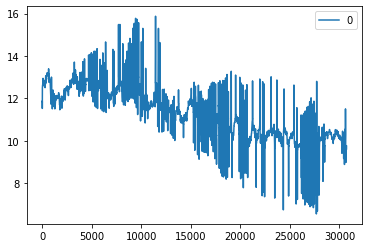

In [16]:
pd.DataFrame(dba_results).plot()

<AxesSubplot:>

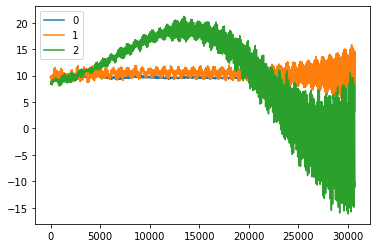

In [12]:
ar_results.plot()

<AxesSubplot:>

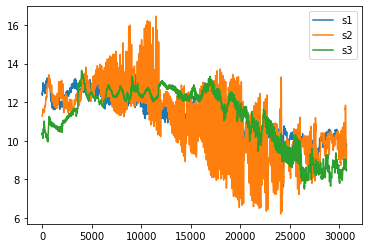

In [14]:
pd.read_csv('/localdata/ABench-IoT/Generation/gan/dcgan_Sauerstoff/correlated.csv')[['s'+str(i) for i in range(1,4)]][:window*10].plot()



In [7]:
import statistics 


print(min(data))
print(max(data))
print(statistics.stdev(data))

print()

df_segments *= 10

print(max(df_segments.min()))
print(max(df_segments.max()))
print(df_segments.std()) 

s1
s3


TypeError: can't convert type 'str' to numerator/denominator

In [ ]:
data = data[:window * 16 ]


In [ ]:
# df_ori = data[:15000]
# noise = np.random.normal(0,.008,len(data))
# generated = list(data + noise)

In [ ]:
plt.plot(data)
plt.show()
# plt.plot(generated)
# plt.show()

In [ ]:
from scipy.signal import lfilter

df_segments = df_segments.T

n = 10  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

for col in tqdm(df_segments):
#     plt.plot(df_segments[col].tolist())
    yy = lfilter(b,a,df_segments[col].tolist())
    yy[:n] = yy[n:n+1]
    df_segments[col] = yy.tolist()
#     plt.plot(df_segments[col].tolist())
#     plt.show()
    
    
# df_segments = pd.DataFrame(segments)
# df_segments = df_segments.T

df_segments.iloc[: , 36:75].plot(subplots=True, layout=(10,6), figsize=(10, 10), legend = False, color = 'black')
plt.show()

In [ ]:
segments = [] 

for col in df_segments:
    segments += [df_segments[col].tolist()]

print(len(segments))

# LSH

In [ ]:
lsh = lshash.LSHash(window // 300, window, num_hashtables=8)

for i in segments:
    lsh.index(i)
    


# results = [list(lsh.query(i)[0][0][0]) for i in segments]

# results = pd.DataFrame(results)
# results = results.T

# results.plot(subplots=True, layout=(5,5), figsize=(10, 5), legend = False, color = 'b')
# plt.show()


In [ ]:
to_query = [data[i:i + window] for i in range(0, len(data) - window, window)]

plt.plot(to_query[0])
plt.show()

plt.plot(random.choice( lsh.query(to_query[0], distance_func="euclidean", num_results=3))[0][0])
plt.show()

# nn = lsh.query(to_query[0], distance_func="euclidean", num_results=10)
# for ((vec,extra_data),distance) in nn:
#     print( distance)
#     plt.plot(vec)
#     plt.show()
#     # len(segments)

In [ ]:
for i in to_query:
    plt.plot(i)
    plt.show()
    plt.plot(random.choice( lsh.query(i, distance_func="euclidean", num_results=10))[0][0])
    plt.show()

In [ ]:
lsh_res = []
n_top = 30
k = int(window * .03)
for i in tqdm(range(to_generate)):
    temp = list(random.choice( lsh.query(to_query[0], distance_func="euclidean", num_results=n_top))[0][0])
    for i in range(1, len(to_query)): 
        candidates = lsh.query(to_query[i], distance_func="euclidean", num_results=n_top)
        s = list(random.choice(candidates)[0][0])
        temp_t = temp[-k:]
        s_h = s[:k]
        overlap = []
        for i in range(-k//2, k//2):
            overlap.append((1 - sigmoid(i))*temp_t[i + k//2] + sigmoid(i)*s_h[i + k//2])
#         for i in range(-1*k , 0):
#             temp[i]= (1 - sigmoid(i))*temp_t[i] + sigmoid(i)*s_h[i]
#         for i in range(0, k):
#             s[i]= (1 - sigmoid(i))*temp_t[i] + sigmoid(i)*s_h[i]
        temp[-k:] = overlap
        s[:k] = overlap[::-1]
        temp.extend(s)
    lsh_res.append(temp)
    
    
# lsh_res = []
# for i in range(3):
#     results = [lsh.query(to_query[i])[0][0][0] for i in range(len(to_query))]
#     print(len(results))
#     res_lsh = []
#     for l in results: 
#         res_lsh += l
#     lsh_res.append(res_lsh)
    


In [ ]:

temp_t = [8.223067268392308, 8.234601459461013, 8.231100734977524, 8.235581871064525, 8.22165953679208, 8.224560530685782, 8.221611838752738, 8.220763007167054, 8.221360251440409, 8.237594346928871, 8.218151884601212, 8.218895522288742, 8.222024050647743, 8.220620320290683, 8.226100869913548]
s_h = [8.203848961187267, 8.215696132997543, 8.211725913440684, 8.229210929937185, 8.231961348404845, 8.226763106150951, 8.232830353263141, 8.22468453854455, 8.222993742737057, 8.236119151230762, 8.202521977215087, 8.226678129771793, 8.223971839312602, 8.20790959411677, 8.228807763790948]
overlap = [8.223067262513386, 8.234601443740704, 8.231100691184144, 8.23558183192035, 8.221659708846982, 8.224560630678013, 8.221613223056579, 8.220764322253114, 8.221361739634606, 8.237590699325827, 8.218047275961117, 8.219035501900985, 8.22211642622594, 8.21910516458973, 8.226828865800433, 8.213458114789788, 8.220780558368093, 8.214035448781532, 8.229513077383112, 8.231776057858188, 8.226748364641713, 8.23280261410438, 8.224680965828703, 8.222993194945538, 8.23611933326191, 8.20252268677957, 8.226677999791182, 8.223971827345048, 8.207909622847135, 8.22880776154009]

plt.plot(temp_t + s_h)
plt.show()
plt.plot(overlap)
plt.show()


In [ ]:
plt.plot(lsh_res[0])
plt.show()

plt.plot(lsh_res[1])
plt.show()

plt.plot(lsh_res[2])
plt.show()

# Graph

In [ ]:
#Calculates the distance between two series. Given series A, B returns the Euclidean distance between A and B
def distance(a, b):
    return np.sqrt(np.sum((a - b)**2))
    
#The probability is converted according to the sorted distances, which adds up to 1
def distopro(a):
    a=len(a)
    if(a==3):
        b=[0.2,0.3,0.5]
    elif(a==4):
        b=[0.1,0.2,0.3,0.4]
    else:
        b=[0.04,0.12,0.2,0.28,0.36]
    return np.array(b)
        

#Input is the original data matrix, return is the relationship matrix relation_matrix, and probability matrix probability_matrix
#Data is the matrix of series, the first dimension is the number of series, and the second dimension is each series
#Window_size is the size of the window to calculate the distance, and k is the number of the nearest neighbors selected. Currently, 3,4,5 are supported
def transform(data, window_size, k):
    numOfSeq=data.shape[0]
    distance_matrix=np.ones([numOfSeq,numOfSeq],dtype = float)
    for i in range(numOfSeq):
        for j in range(numOfSeq):
            distance_matrix[i][j]=distance(data[i,data.shape[1]-window_size:],data[j,0:window_size])
    relation_matrix=np.ones([numOfSeq,k],dtype = int)
    subdistance_matrix=np.ones([numOfSeq,k],dtype = float)
    probability_matrix=np.ones([numOfSeq,k],dtype = float)
    for i in range(numOfSeq):
        relation_matrix[i]=distance_matrix[i].argsort()[::-1][data.shape[0]-k:]
        #print(relation_matrix[i])
#     print(relation_matrix[i])
    for i in range(numOfSeq):
        for j in range(k):
            subdistance_matrix[i][j]=distance_matrix[i][relation_matrix[i][j]]
    
    for i in range(numOfSeq):
        probability_matrix[i]=distopro(subdistance_matrix[i])
    
    
    return distance_matrix, subdistance_matrix ,relation_matrix, probability_matrix
            
      
#print(transform(np.array([[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0]]), 2, 3))


#Given the ID of the current series, the ID of the next series is generated randomly according to probability
def next_step(relation_array, probability_array):
    value=random.random()
#     print(value)
    threshold=[0]
    sum_value=0
    for i in range(len(probability_array)):
        sum_value=sum_value+probability_array[i]
        threshold.append(sum_value)
    for i in range(len(threshold)-1):
        if(value>threshold[i] and value<=threshold[i+1]):
            return relation_array[i]

#Given a relation matrix and a probability matrix, returns a series of length        
def random_walk(relation_matrix, probability_matrix, length):
    seq=[0]
    temp_id=0
    for i in range(length-1):
        temp_id=next_step(relation_matrix[temp_id],probability_matrix[temp_id])
        seq.append(temp_id)
        #print(temp_id)
    return np.array(seq)

In [ ]:
seq=[0]

a,b,c,d=transform(np.array(segments), 100, 5)

In [ ]:
graph_res = []
for i in range(to_generate):
    path = random_walk( c, d, int(len(data)/window))
    print(path)
    temp=[]
    for s in path:
#         print(path[i], i)
        temp+=list(segments[s])
    graph_res.append(temp)
    print(len(graph_res))
    

In [ ]:
print(graph_res[0][-3:-1])
print(graph_res[1][-3:-1])
print(graph_res[2][-3:-1])

In [ ]:

# res_lsh = pd.read_csv('example_data.csv')
# res_lsh = res_lsh['LSH'].tolist()

# res_graph = pd.read_csv('example_data.csv')
# res_graph = res_graph['Graph'].tolist()

In [ ]:
plt.plot(segments[0])
plt.show()

In [ ]:
xi = list(range(10000))
# plot the index for the x-values 

plt.figure(figsize=(60*2, 80))

plt.subplot(to_generate*2+1, 1, 1)

# plt.figure(figsize=(60, 8))
plt.plot(data,color='blue',linewidth=4.0, label='Original')
plt.xlim(0,len(lsh_res[0]))

for i in range(to_generate):
    plt.subplot(to_generate*2+1, 1, i+2)
    plt.plot(lsh_res[i],color='green',linewidth=4.0, label='LSH')
    plt.xlim(0,len(lsh_res[0]))
    
for i in range(to_generate):
    plt.subplot(to_generate*2+1, 1, i+2+to_generate)
    plt.plot(graph_res[i],color='red',linewidth=4.0, label='Graph')
    plt.xlim(0,len(lsh_res[0]))


# lines, labels = fig.axes[-1].get_legend_handles_labels()
# print(lines, labels)
# fig.legend(lines, labels, loc = 'upper right')

plt.show()

# plt.show()
# plt.savefig('plot_lsh_graph.pdf',dpi=1600,
#             bbox_inches = 'tight')



In [ ]:
plt.plot(lsh_res[1][5830:5840],color='red')
plt.ylim(8.1,8.7)
plt.show()

# Metrics

In [ ]:
from numpy import pi
from scipy import ndimage
from scipy.integrate._bvp import EPS
from scipy.linalg import det
from scipy.special import gamma, psi
from scipy.stats import pearsonr, spearmanr
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest

def mutual_information_2d(x, y, sigma=1, normalized=False):
    """
    Computes (normalized) mutual information between two 1D variate from a
    joint histogram.
    Parameters
    ----------
    x : 1D array
        first variable
    y : 1D array
        second variable
    sigma: float
        sigma for Gaussian smoothing of the joint histogram
    Returns
    -------
    nmi: float
        the computed similariy measure
    """
    bins = (256, 256)

    jh = np.histogram2d(x, y, bins=bins)[0]

    # smooth the jh with a gaussian filter of given sigma
    ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                            output=jh)

    # compute marginal histograms
    jh = jh + EPS
    sh = np.sum(jh)
    jh = jh / sh
    s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
    s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

    # Normalised Mutual Information of:
    # Studholme,  jhill & jhawkes (1998).
    # "A normalized entropy measure of 3-D medical image alignment".
    # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
    if normalized:
        mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
              / np.sum(jh * np.log(jh))) - 1
    else:
        mi = (np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
              - np.sum(s2 * np.log(s2)))

    return mi


In [ ]:
from sklearn.metrics import mean_squared_error
from  math import sqrt
import statistics
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import skew
from scipy.stats import kurtosis
from dtw import dtw, accelerated_dtw

def anomaly_score(df):
    final = []
    for i in range(1):
        isolation_forest = IsolationForest(n_estimators=100)
        isolation_forest.fit(df.values.reshape(-1, 1))
        xx = np.linspace(df.min(), df.max(), len(df)).reshape(-1, 1)
        # anomaly_score = isolation_forest.decision_function(xx)
        outlier = isolation_forest.predict(xx)

        # getting anomaly score for each value
        anos = []
        for index, v in df.items():
            idx = int((v - df.min()) / ((df.max() - df.min()) / len(xx))) - 1
            anos.append(outlier[idx] == -1)
        anos = np.array(anos)
        final.append(len(anos[anos == True]) / len(anos))
    # return len(anos[anos == True]) / len(anos)
    return sum(final) / len(final)


def compute_metrics(original, generated):
    metrics = {}


    from sklearn.metrics import mean_squared_error
    from  math import sqrt
    metrics['rmse^-1'] = 1/float(math.sqrt(mean_squared_error(original, generated)))
    # print('RMSE: %f' % metrics['rmse'])  # # original = original.iloc[0]
    
    import statistics
    metrics['mean_dist^-1'] = 1/abs(statistics.mean(original) - statistics.mean(generated))
    metrics['stddev_dist^-1'] = 1/abs(statistics.stdev(original) - statistics.stdev(generated))

    # metrics['DTW'], cost_matrix, acc_cost_matrix, path = float(accelerated_dtw(np.array(original), np.array(generated),
    #                                                                      dist='euclidean'))
    # # print('DTW Distance: %f' % metrics['DTW'])
    #
    # with HiddenPrints():
    #     metrics['MJC'], _ = float(MJC(original, generated))
    # # metrics['MJC'], _ =  1, 1
    #
    from scipy import stats
    metrics['pcorr'] = float(stats.pearsonr(original, generated)[0])
    # # # print('Pearsons correlation: %.3f' % metrics['pcorr'])
    # #
#     metrics['scorr'] = float(stats.spearmanr(original, generated)[0])
    # # # print('Spearmans correlation: %.3f' % metrics['scorr'])
    # #
    from scipy.stats import chi2_contingency

    def calc_MI(x, y, bins=10):
        c_xy = np.histogram2d(x, y, bins)[0]
        g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood")
        mi = 0.5 * g / c_xy.sum()
        return mi
    metrics['NMI'] = float(mutual_information_2d(np.array(original), np.array(generated), sigma=1, normalized=False))
    # # # print('NMI: %.3f' % metrics['NMI'])
    # #
    # plt.clf()
    # plt.title("Autocorrelation Plot")
    # plt.xlabel("Lags")
    # plt.acorr(generated, maxlags = 10)
    # plt.grid(True)
    # plt.savefig(exportPath + "autocorr_generated.png")
    # plt.clf()

#     metrics['Skewness ori'] = float(pd.DataFrame(original).skew())
#     metrics['Skewness gen'] = float(pd.DataFrame(generated).skew())
#     metrics['Kurtosis ori'] = float(pd.DataFrame(original).kurt())
#     metrics['Kurtosis gen'] = float(pd.DataFrame(generated).kurt())
    from scipy.stats import skew
    from scipy.stats import kurtosis

#     metrics['Skewness ori'] = float(skew(original, axis=0, bias=True))
#     metrics['Skewness gen'] = float(skew(generated, axis=0, bias=True))
#     metrics['Kurtosis ori'] = float(kurtosis(original, axis=0, bias=True))
#     metrics['Kurtosis gen'] = float(kurtosis(generated, axis=0, bias=True))
    

    metrics['Skewness^-1'] = 1/abs(skew(original, axis=0, bias=True) - skew(generated, axis=0, bias=True))
    metrics['Kurtosis^-1'] = 1/abs(kurtosis(original, axis=0, bias=True) - kurtosis(generated, axis=0, bias=True))    
    # # print("Skewness: %f" % df.skew())
    # # print("Kurtosis: %f" % df.kurt())
    #
#     ano_original = anomaly_score(pd.Series(original))
#     # # # print('ano_original: %.3f' % metrics['ano_original'])

#     ano_generated = float(anomaly_score(pd.Series(generated)))
#     # print('ano_generated: %.3f' % metrics['ano_generated'])

#     metrics['ano_dist^-1'] = 1/abs(ano_generated - ano_original)
#     # print('ano_distance: %.3f' % metrics['ano_distance'])
    return metrics


def compute_metrics_many(original, generated):
    metrics = {}
    list_metrics = ['rmse^-1','mean_dist^-1','stddev_dist^-1','DTW','pcorr','scorr','NMI','Skewness_dist^-1','Kurtosis_dist^-1']
    for m in list_metrics:
        metrics[m] = []
    
    for gen in tqdm(generated):
        gen = gen[:len(original)]
        metrics['rmse^-1'].append(1/float(math.sqrt(mean_squared_error(original, gen))))
        metrics['mean_dist^-1'].append(1/abs(statistics.mean(original) - statistics.mean(gen)))

#         dtw, cost_matrix, acc_cost_matrix, path = float(accelerated_dtw(np.array(original), np.array(gen),
#                                                                               dist='euclidean'))
#         metrics['DTW'].append(dtw)
        metrics['pcorr'].append(abs(float(stats.pearsonr(original, gen)[0])))
        metrics['scorr'].append(abs(float(stats.spearmanr(original, gen)[0])))
        def calc_MI(x, y, bins=10):
            c_xy = np.histogram2d(x, y, bins)[0]
            g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood")
            mi = 0.5 * g / c_xy.sum()
            return mi
        metrics['NMI'].append(float(mutual_information_2d(np.array(original), np.array(gen), sigma=1, normalized=False)))
        

        metrics['Skewness_dist^-1'].append(1/abs(skew(original, axis=0, bias=True) - skew(gen, axis=0, bias=True)))
        metrics['Kurtosis_dist^-1'].append(1/abs(kurtosis(original, axis=0, bias=True) - kurtosis(gen, axis=0, bias=True)))
    for m in list_metrics:
        try: 
            metrics[m] = sum(metrics[m])/len(metrics[m])
        except: 
            metrics.pop(m, None)
    return metrics



In [ ]:
ori_sample = data[:len(lsh_res[0])]
lsh_sample = lsh_res[1]
graph_sample = graph_res[1][:len(lsh_res[0])]
random_sample = [random.random() for i in range(len(lsh_res[0]))]


In [ ]:
# metrics_lsh = compute_metrics(ori_sample, lsh_sample)
# metrics_graph = compute_metrics(ori_sample, graph_sample)
# metrics_naive = compute_metrics(ori_sample, random_sample)


In [ ]:
metrics_lsh = compute_metrics_many(ori_sample, lsh_res)
metrics_graph = compute_metrics_many(ori_sample, graph_res)
metrics_naive = compute_metrics_many(ori_sample, [[random.random() for i in range(len(lsh_res[0]))] for i in range(to_generate)])


In [ ]:
df_metrics = pd.DataFrame([metrics_lsh,metrics_graph,metrics_naive]).T
df_metrics.columns = ["LSH", "Graph", "Random"]
df_metrics

In [ ]:
df_metrics.div(df_metrics.max(axis=1), axis=0).abs()*100


In [ ]:
fig, ax = plt.subplots()
ax.hist(ori_sample , 20, None, fc='none', lw=1.5, histtype='step', label='original')
ax.hist(lsh_sample, 20, None, fc='none', lw=1.5, ec = 'green', histtype='step', label='lsh')
ax.hist(graph_sample, 20, None, ec = 'red', fc='none', lw=1.5, histtype='step', label='graph')
ax.legend(loc='upper left')
# plt.show()
plt.savefig('histograms.pdf',dpi=1600,
            bbox_inches = 'tight')

In [ ]:
plt.hist(data, bins=50, alpha=0.5)
plt.show()
plt.hist(lsh_res[0], bins=50, alpha=0.5)
plt.show()
# plt.hist(graph_res[0], bins=50, alpha=0.5)
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(60, 40))

plt.style.use('seaborn-deep')

plt.yscale('log',base=2) 
plt.hist([data, res_lsh, res_graph], bins=10, label=['Original', 'LSH', 'Graph'])

plt.legend(loc="upper right", prop={'size': 80})

plt.savefig('plot_distribution.pdf',dpi=1600,
            bbox_inches = 'tight')
# plt.show()